# Onboard a Doctor in Training
## Role: Lead Employer

The lead employer is responsible for verifying GMC licences and issuing credentials needed by new doctors before they can begin specific placements. These include; dbs checks, mandatory training, occupational health and assigment credentials.

## Before running through this notebook you should run through the following notebook - [Part 5.1](http://localhost:8892/notebooks/Part%205.1%20-%20Initialising%20the%20Lead%20Employer%20Agent.ipynb).

## Or alternatively you can start at the beginning of the Doctors in Training flow [here](http://localhost:8889/notebooks/Part%201%20-%20Getting%20Started.ipynb).



## 1. Initialise a controller for the Lead Employer

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8062
WEBHOOK_BASE = ""
ADMIN_URL = "http://lead-employer-agent:8061"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scans this QR code and then can communicate with the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

You must have a ssi wallet installed on your phone and connected to the Sovrin StagingNet for this to work.

### 3.1 Generate an invitation

In [3]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'connection_id': 'ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e', 'invitation_key': '34FVD18rFvjFRYVPEGhCPybPZocuuhHwpvZEC7exZEXi', 'state': 'invitation', 'created_at': '2020-09-21 18:28:37.383279Z', 'accept': 'auto', 'invitation_mode': 'once', 'initiator': 'self', 'routing_state': 'none', 'updated_at': '2020-09-21 18:28:37.383279Z'} ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e
Connection ID ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e
Invitation
https://44d1b19d89ec.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiODE5OTNiYjItYmY0ZS00ZmEwLTkzMWEtOTE5MTQzM2EyODkyIiwgImxhYmVsIjogIk5IUyBMZWFkIEVtcGxveWVyIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovLzQ0ZDFiMTlkODllYy5uZ3Jvay5pbyIsICJyZWNpcGllbnRLZXlzIjogWyIzNEZWRDE4ckZ2akZSWVZQRUdoQ1B5YlBab2N1dWhId3B2WkVDN2V4WkVYaSJdfQ==


### 3.2 Display as QrCode to be Scanned by SSI Wallet

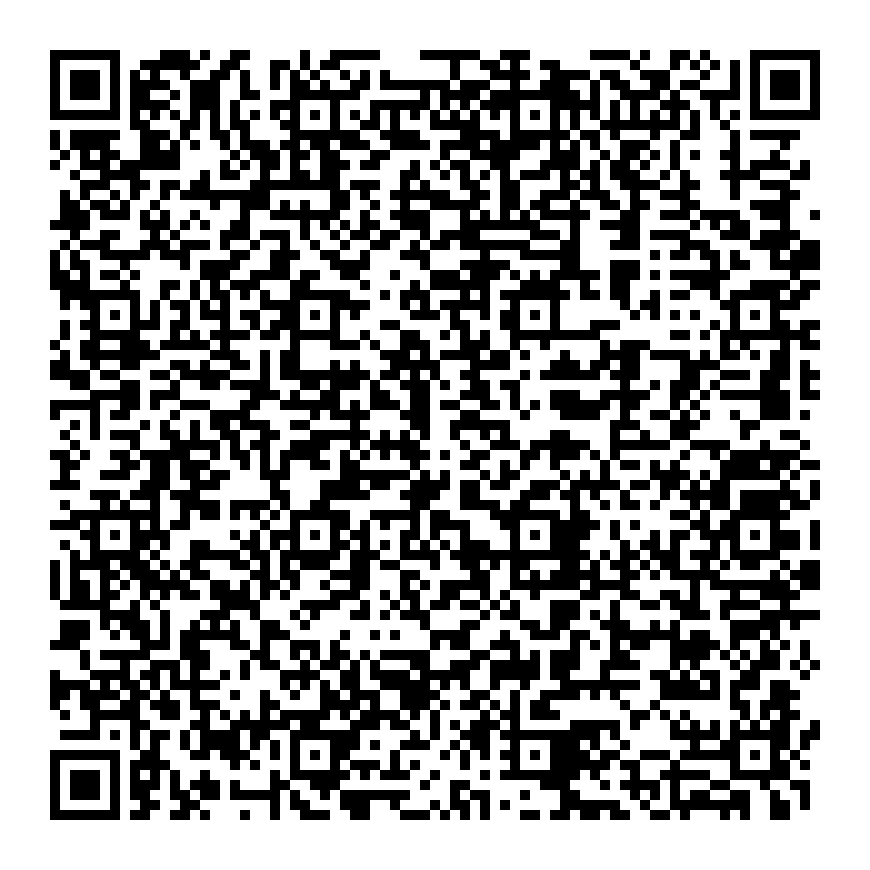

Connection message {'connection_id': 'ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e', 'invitation_key': '34FVD18rFvjFRYVPEGhCPybPZocuuhHwpvZEC7exZEXi', 'state': 'request', 'their_label': 'esatus Wallet', 'created_at': '2020-09-21 18:28:37.383279Z', 'their_did': '3ujYysfpAZSErEkLHFRyWg', 'accept': 'auto', 'invitation_mode': 'once', 'initiator': 'self', 'routing_state': 'none', 'updated_at': '2020-09-21 18:29:00.515448Z'} ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e
Connection message {'connection_id': 'ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e', 'invitation_key': '34FVD18rFvjFRYVPEGhCPybPZocuuhHwpvZEC7exZEXi', 'state': 'response', 'their_label': 'esatus Wallet', 'created_at': '2020-09-21 18:28:37.383279Z', 'my_did': 'Gu6U7Xz4kpEgW18udV2Sw7', 'their_did': '3ujYysfpAZSErEkLHFRyWg', 'accept': 'auto', 'invitation_mode': 'once', 'initiator': 'self', 'routing_state': 'none', 'updated_at': '2020-09-21 18:29:00.548256Z'} ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e


In [4]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)

qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

### 3.3 Check the connection is in the active state

In [5]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e is response
ConnectionId ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e is not in active state yet
Trust ping send to ConnectionId {'thread_id': 'a6937c48-8ede-49d7-8a70-99e200a635d7'} to activate connection
ConnectionId ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e is not in active state yet
Connection message {'connection_id': 'ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e', 'invitation_key': '34FVD18rFvjFRYVPEGhCPybPZocuuhHwpvZEC7exZEXi', 'state': 'active', 'their_label': 'esatus Wallet', 'created_at': '2020-09-21 18:28:37.383279Z', 'my_did': 'Gu6U7Xz4kpEgW18udV2Sw7', 'their_did': '3ujYysfpAZSErEkLHFRyWg', 'accept': 'auto', 'invitation_mode': 'once', 'initiator': 'self', 'routing_state': 'none', 'updated_at': '2020-09-21 18:29:10.912306Z'} ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e
Connection ecd5a6fa-5ab7-4c6c-bfd8-9ef49ff85f9e changed state to active
Trust ping send to ConnectionId {'thread_id': 'c67e4621-da35-43e4-be46-61fcfa165762'} to activate 

## 4 Issue a DBS Check Credential

This would be after first running one of course.

### 4.1 Fetch the stored cred def and schema id written to the ledger in Part 5.1


In [6]:
%store -r dbs_schema_id
%store -r dbs_cred_def_id
print(dbs_schema_id)
print(dbs_cred_def_id)
    


2yWoMSfeTtYBFpUJFcnpqL:2:DBS Criminal Record Check:0.0.1
51CjicBWofzajTByNQnfo2:3:CL:141274:default


### 4.2 Populate the Training Program attributes to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [11]:
## TODO These can be fetched from a presentation request

surname = "Johnson"
forename = "Fred"
othernames = ""
dob = "05/03/2000"
placeofbirth = "Bradford"
gender = "Male"


Today's date: 2020-09-21


In [17]:
from datetime import date

today = str(date.today())
dbs_level = input("Please enter the level of DBS check requested: ")
position=input("Please enter the position the check was requested for: ")
adult_list=input("Check against the Adult's list: ")
child_list = input("Check against the Children's list: ")
police=input("Check against the Police Records: ")
education=input("Check against the Education Act: ")
relevant_info=input("Check against other relevant info: ")

employer=input("Please enter the name of the employer: ")
registered_body = input("Please enter the registered person/body: ")
countersignatory=input("Who is the countersignatory: ")
cert_num = input("What is the certificate reference number")

credential_attributes = [
     {"name": "DBS Surname","value": surname},
     {"name": "DBS Forename","value": forename},
     {"name": "DBS Other Names","value": othernames},
     {"name": "DBS Date of Birth","value": dob},
     {"name": "DBS Place of Birth","value": placeofbirth},
     {"name": "DBS Gender","value": gender},
     {"name": "DBS Date of Issue","value": today},
     {"name": "DBS Level of Check Requested","value": dbs_level},
     {"name": "DBS Position Check Applied For","value": position},
     {"name": "DBS Check Against Adult's List","value": adult_list},
     {"name": "DBS Check Against Children's List","value": child_list},
     {"name": "DBS Check Against Police Records","value": police},
     {"name": "DBS Check Information From Section 142 Education Act 2002","value": education},
     {"name": "DBS Check for Other Relevant Information","value": relevant_info},
     {"name": "DBS Name of Employer","value": employer},
     {"name": "DBS Registered Person/Body","value": registered_body},
     {"name": "DBS Countersignatory","value": countersignatory},
     {"name": "DBS Certificate Reference Number","value": cert_num},

]




print(credential_attributes)

Please enter the level of DBS check requested: asd
Please enter the position the check was requested for: asd
Check against the Adult's list: sad
Check against the Children's list: asd
Check against the Police Records: as
Check against the Education Act: asd
Check against other relevant info: sda
Please enter the name of the employer: asd
Please enter the registered person/body: ads
Who is the countersignatory: ads
What is the certificate reference numberads
[{'name': 'DBS Surname', 'value': 'Johnson'}, {'name': 'DBS Forename', 'value': 'Fred'}, {'name': 'DBS Other Names', 'value': ''}, {'name': 'DBS Date of Birth', 'value': '05/03/2000'}, {'name': 'DBS Place of Birth', 'value': 'Bradford'}, {'name': 'DBS Gender', 'value': 'Male'}, {'name': 'DBS Date of Issue', 'value': '2020-09-21'}, {'name': 'DBS Level of Check Requested', 'value': 'asd'}, {'name': 'DBS Position Check Applied For', 'value': 'asd'}, {'name': "DBS Check Against Adult's List", 'value': 'sad'}, {'name': "DBS Check Agains

## 4.3 Issue Training Program Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [18]:
record = await agent_controller.issuer.send_credential(connection_id, dbs_schema_id, dbs_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Credential exchange 7bf69b03-8244-47dd-b28f-7a836faa6c01, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 7bf69b03-8244-47dd-b28f-7a836faa6c01, role: issuer, state: offer_sent
Offering: [{'name': 'DBS Surname', 'value': 'Johnson'}, {'name': 'DBS Forename', 'value': 'Fred'}, {'name': 'DBS Other Names', 'value': ''}, {'name': 'DBS Date of Birth', 'value': '05/03/2000'}, {'name': 'DBS Place of Birth', 'value': 'Bradford'}, {'name': 'DBS Gender', 'value': 'Male'}, {'name': 'DBS Date of Issue', 'value': '2020-09-21'}, {'name': 'DBS Level of Check Requested', 'value': 'asd'}, {'name': 'DBS Position Check Applied For', 'value': 'asd'}, {'name': "DBS Check Against Adult's List", 'value': 'sad'}, {'name': "DBS Check Against Children's List", 'value': 'asd'}, {'name': 'DBS Check Against Police Records', 'value': 'as'}, {'name': 'DBS Check Information From Section 142 Education Act 2002', 'value': 'asd'}, {'name': 'DBS Check for Other Relevant Information', 'value': 'sda'},

## 5. Issue Mandatory Training Credential

### 5.1 Retrieve stored credential definitions and schema


In [19]:
%store -r mandatory_training_schema_id
%store -r mandatory_training_cred_def_id
print(mandatory_training_schema_id)    
print(mandatory_training_cred_def_id)

2yWoMSfeTtYBFpUJFcnpqL:2:mandatoryTrainingCredential:0.0.1
51CjicBWofzajTByNQnfo2:3:CL:141271:default


### 5.2 Populate the Mandatory Training Credential Attributes

This appears to be a terribly designed schema that makes it almost unusable. Are doctors ever going to complete all this training all at once? Why not break it up into the individual segments? Is this to save costs when writing too the ledger?

In [20]:
expiry_date = input("Please enter the expiry date for all training :")

credential_attributes=[
    {"name":"MNT Conflict Resolution Completed", "value": "True"},
     {"name":"MNT Conflict Resolution Expiry Date", "value": expiry_date},
     {"name":"MNT Equality and Diversity Completed", "value": "True"},
     {"name":"MNT Equality and Diversity Expiry Date", "value": expiry_date},
     {"name":"MNT Fire Safety Completed", "value": "True"},
     {"name":"MNT Fire Safety Expiry Date", "value": expiry_date},
     {"name":"MNT Health Safety and Welfare Completed", "value": "True"},
     {"name":"MNT Health Safety and Welfare Expiry Date", "value": expiry_date},
     {"name":"MNT Infection Prevention L1 Completed", "value": "True"},
     {"name":"MNT Infection Prevention L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Infection Prevention L2 Completed", "value": "True"},
     {"name":"MNT Infection Prevention L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Information Governance Completed", "value": "True"},
     {"name":"MNT Information Governance Expiry Date", "value": expiry_date},
     {"name":"MNT Moving and Handling L1 Completed", "value": "True"},
     {"name":"MNT Moving and Handling L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Moving and Handling L2 Completed", "value": "True"},
     {"name":"MNT Moving and Handling L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Basic Prevent Awareness Completed", "value": "True"},
     {"name":"MNT Basic Prevent Awareness Expiry Date", "value": expiry_date},
     {"name":"MNT Prevent Awareness Completed", "value": "True"},
     {"name":"MNT Prevent Awareness Expiry Date", "value": expiry_date},
     {"name":"MNT Resus L1 Completed", "value": "True"},
     {"name":"MNT Resus L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Resus L2 Adult Completed", "value": "True"},
     {"name":"MNT Resus L2 Adult Expiry Date","value": expiry_date},
     {"name":"MNT Resus L2 Newborn Completed", "value": "True"},
     {"name":"MNT Resus L2 Newborn Expiry Date", "value": expiry_date},
     {"name": "MNT Resus L2 Paediatric Completed", "value": "True"},
     {"name":"MNT Resus L2 Paediatric Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L1 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L2 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L3 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L3 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L1 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L2 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L3 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L3 Expiry Date", "value": expiry_date},
     {"name":"MNT Violence and Aggression Completed", "value": "True"},
     {"name":"MNT Violence and Aggression Expiry Date", "value": expiry_date}
]
print(credential_attributes)


Please enter the expiry date for all training :12/12/21
[{'name': 'MNT Conflict Resolution Completed', 'value': 'True'}, {'name': 'MNT Conflict Resolution Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Equality and Diversity Completed', 'value': 'True'}, {'name': 'MNT Equality and Diversity Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Fire Safety Completed', 'value': 'True'}, {'name': 'MNT Fire Safety Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Health Safety and Welfare Completed', 'value': 'True'}, {'name': 'MNT Health Safety and Welfare Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Infection Prevention L1 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L1 Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Infection Prevention L2 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L2 Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Information Governance Completed', 'value': 'True'}, {'name': 'MNT Information Governance Expiry Date', 'va

### 5.3 Issue the Mandatory Training Credential 

In [21]:
record = await agent_controller.issuer.send_credential(connection_id, mandatory_training_schema_id, mandatory_training_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Credential exchange 49964ff4-c82b-4f9b-8ee2-f8dedeba7136, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 49964ff4-c82b-4f9b-8ee2-f8dedeba7136, role: issuer, state: offer_sent
Offering: [{'name': 'MNT Conflict Resolution Completed', 'value': 'True'}, {'name': 'MNT Conflict Resolution Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Equality and Diversity Completed', 'value': 'True'}, {'name': 'MNT Equality and Diversity Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Fire Safety Completed', 'value': 'True'}, {'name': 'MNT Fire Safety Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Health Safety and Welfare Completed', 'value': 'True'}, {'name': 'MNT Health Safety and Welfare Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Infection Prevention L1 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L1 Expiry Date', 'value': '12/12/21'}, {'name': 'MNT Infection Prevention L2 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L2 Expi

## 6. Issue Occupational Health Credential

### 6.1 Retrieve stored cred def and schemas

In [22]:
%store -r occ_health_schema_id
%store -r occ_health_cred_def_id
print(occ_health_schema_id)
print(occ_health_cred_def_id)

2yWoMSfeTtYBFpUJFcnpqL:2:Occupational Health:0.0.1
51CjicBWofzajTByNQnfo2:3:CL:141273:default


### 6.2 Populate the Occupational Health Attributes

In [24]:
today = str(date.today())

skin_test = input("Please enter the skin test result: ")
pox=input("Please enter the History of Ch. Pox or Shingles: ")
tb=input("Has the doctor ever had exposure to TB : ")
tb_treatment=input("Has the doctor ever been treated for TB : ")

chest = input("Please enter the result of a TB Chest X-Ray: ")
allergies = input("Does the doctor have any alergies: ")

credential_attributes = [
     {"name":"OCH DTP Imm. Date","value": today},
     {"name":"OCH DTP Serology Date","value": today},
     {"name":"OCH Hep B Imm. Course Date","value": today},
     {"name":"OCH Hep B Booster Date","value": today},
     {"name":"OCH Hep B sAg Serology Date","value": today},
     {"name":"OCH Hep B Ab Date","value": today},
     {"name":"OCH Hepatitis C Serology Date","value": today},
     {"name":"OCH MMR Foundation Shot 1 Date","value": today},
     {"name":"OCH MMR Foundation Shot 2 Date","value": today},
     {"name":"OCH Varicella Imm. Course Date","value": today},
     {"name":"OCH Varicella Ab Date","value": today},
     {"name":"OCH Measles Ab Date","value": today},
     {"name":"OCH Rubella Ab Date","value": today},
     {"name":"OCH HIV Serology Date","value": today},
     {"name":"OCH BCG Vacc. Date","value": today},
     {"name":"OCH TB Skin Test Result","value": skin_test},
     {"name":"OCH History of Ch. Pox or Shingles","value": pox},
     {"name":"OCH History of Exp. to TB (or ever investig.)","value": tb},
     {"name":"OCH Ever Treated for TB","value": tb_treatment},
     {"name":"OCH Chest X-Ray Outcome if Exp. to TB","value": chest},
     {"name":"OCH Allergies","value": allergies},

]
print(credential_attributes)

Please enter the skin test result: Negative
Please enter the History of Ch. Pox or Shingles: No
Has the doctor ever had exposure to TB : No
Has the doctor ever been treated for TB : No
Please enter the result of a TB Chest X-Ray: No
Does the doctor have any alergies: No
[{'name': 'OCH DTP Imm. Date', 'value': '2020-09-21'}, {'name': 'OCH DTP Serology Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Imm. Course Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Booster Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B sAg Serology Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Hepatitis C Serology Date', 'value': '2020-09-21'}, {'name': 'OCH MMR Foundation Shot 1 Date', 'value': '2020-09-21'}, {'name': 'OCH MMR Foundation Shot 2 Date', 'value': '2020-09-21'}, {'name': 'OCH Varicella Imm. Course Date', 'value': '2020-09-21'}, {'name': 'OCH Varicella Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Measles Ab Date', 'value': '2020-09-2

### 6.3 Issue the Training Placement Credential

In [25]:
record = await agent_controller.issuer.send_credential(connection_id, occ_health_schema_id, occ_health_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Credential exchange a3f16c2a-c624-4d1d-8286-97daf1112e18, role: issuer, state: offer_sent
Handle Credentials
Credential exchange a3f16c2a-c624-4d1d-8286-97daf1112e18, role: issuer, state: offer_sent
Offering: [{'name': 'OCH DTP Imm. Date', 'value': '2020-09-21'}, {'name': 'OCH DTP Serology Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Imm. Course Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Booster Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B sAg Serology Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Hepatitis C Serology Date', 'value': '2020-09-21'}, {'name': 'OCH MMR Foundation Shot 1 Date', 'value': '2020-09-21'}, {'name': 'OCH MMR Foundation Shot 2 Date', 'value': '2020-09-21'}, {'name': 'OCH Varicella Imm. Course Date', 'value': '2020-09-21'}, {'name': 'OCH Varicella Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Measles Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Rubella Ab Date', 'value': '2020-09-21'}, {

Handle Credentials
Credential exchange a3f16c2a-c624-4d1d-8286-97daf1112e18, role: issuer, state: request_received
Offering: [{'name': 'OCH DTP Imm. Date', 'value': '2020-09-21'}, {'name': 'OCH DTP Serology Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Imm. Course Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Booster Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B sAg Serology Date', 'value': '2020-09-21'}, {'name': 'OCH Hep B Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Hepatitis C Serology Date', 'value': '2020-09-21'}, {'name': 'OCH MMR Foundation Shot 1 Date', 'value': '2020-09-21'}, {'name': 'OCH MMR Foundation Shot 2 Date', 'value': '2020-09-21'}, {'name': 'OCH Varicella Imm. Course Date', 'value': '2020-09-21'}, {'name': 'OCH Varicella Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Measles Ab Date', 'value': '2020-09-21'}, {'name': 'OCH Rubella Ab Date', 'value': '2020-09-21'}, {'name': 'OCH HIV Serology Date', 'value': '2020-09-21'}, {'name': 'OCH BCG Vacc. Dat

## 7. Issue the Doctor an Assignment Credential

### 7.1 Retrieve cred def and schema id's from storage

In [26]:
%store -r lead_emp_schema_id
%store -r lead_emp_cred_def_id
print(lead_emp_schema_id)
print(lead_emp_cred_def_id)

2yWoMSfeTtYBFpUJFcnpqL:2:Lead Employer Assignment:0.0.1
51CjicBWofzajTByNQnfo2:3:CL:141275:default


## 7.2 Populate the Assigment attributes

In [27]:
emp_org = input("Enter the employing organisation for this assignment: ")
ods_code = input("Enter the employing organisation ODS Code:")
job_title = input("Enter the assignment job title: ")
start = input("Enter the assignment start date:")
end_date = input("Enter the assignment end date")
department = input("Enter the department:")
staff_group = input("Enter the staff group:")
role = input("Enter the job role:")
pay_band = input("Enter the assignment Pay Band:")
area = input("Enter the area of work:")
occ_code = input("Enter the Occupation Code:")
smartcard = input("Enter the smartcard number")

credential_attributes = [
     {"name":"LEA Employing Org","value": emp_org},
     {"name":"LEA Employing Org ODS Code","value": ods_code},
     {"name":"LEA Job Title","value": job_title},
     {"name":"LEA Start Date","value": start},
     {"name":"LEA Fixed Term Contract End Date","value": today},
     {"name":"LEA Department","value": department},
     {"name":"LEA Staff Group","value": staff_group},
     {"name":"LEA Job Role","value": role},
     {"name":"LEA Pay Band Afc","value": pay_band},
     {"name":"LEA Area Of Work","value": area},
     {"name":"LEA Occupation Code","value": occ_code},
     {"name":"LEA Smartcard Number","value": smartcard},
]

print(credential_attributes)

Enter the employing organisation for this assignment: BTH
Enter the employing organisation ODS Code:123
Enter the assignment job title: Boss
Enter the assignment start date:today
Enter the assignment end datetomorrow
Enter the department:Work
Enter the staff group:Working
Enter the job role:Work
Enter the assignment Pay Band:Top
Enter the area of work:Top
Enter the Occupation Code:123
Enter the smartcard number123


## 7.3 Issue the Lead Employer Assignment Credential

In [28]:
record = await agent_controller.issuer.send_credential(connection_id, lead_emp_schema_id, lead_emp_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Credential exchange a699d804-8be0-45ec-bc01-acd4d7c81727, role: issuer, state: offer_sent
Handle Credentials
Credential exchange a699d804-8be0-45ec-bc01-acd4d7c81727, role: issuer, state: offer_sent
Offering: [{'name': 'LEA Employing Org', 'value': 'BTH'}, {'name': 'LEA Employing Org ODS Code', 'value': '123'}, {'name': 'LEA Job Title', 'value': 'Boss'}, {'name': 'LEA Start Date', 'value': 'today'}, {'name': 'LEA Fixed Term Contract End Date', 'value': '2020-09-21'}, {'name': 'LEA Department', 'value': 'Work'}, {'name': 'LEA Staff Group', 'value': 'Working'}, {'name': 'LEA Job Role', 'value': 'Work'}, {'name': 'LEA Pay Band Afc', 'value': 'Top'}, {'name': 'LEA Area Of Work', 'value': 'Top'}, {'name': 'LEA Occupation Code', 'value': '123'}, {'name': 'LEA Smartcard Number', 'value': '123'}]
Handle Credentials
Credential exchange a699d804-8be0-45ec-bc01-acd4d7c81727, role: issuer, state: request_received
Offering: [{'name': 'LEA Employing Org', 'value': 'BTH'}, {'name': 'LEA Employing Org

## 7. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [12]:
response = await agent_controller.terminate()
print(response)

None


# You can now proceed to interact with the [Lead Employer](http://127.0.0.1:8892)
